<h3>
Part 1 : Groups of products with similar descriptions¶
<h3>
<h6> 
For this part, you'll have to train a clustering model that will create groups of products for which the descriptions are "close" to each other.

You can use DBSCAN to make some clustering on the TF-IDF matrix. When dealing with texts, the distance metric to be used is "cosine" instead of "euclidean". You have to find some values for eps and min_samples that allow to get 10-20 clusters and not too many outliers.
You can display a wordcloud for each cluster to analyze the results and see if the groups contain different words.
<h6>

In [1]:
# Install spacy 
## -q is for "quiet". It removes logs 
!pip install spacy -q
# Import spacy, if you don't have it --> !pip install spacy 
import spacy
spacy.__version__

# Download model 
!python -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS
import matplotlib.pyplot as plt
!pip install wordcloud -q
import wordcloud

nlp = en_core_web_sm.load()

In [174]:
df = pd.read_csv('sample-data.csv')

In [175]:
print(f'The size of the dataset is {df.shape}')
print(f'The names of columns are the following {df.columns}')

The size of the dataset is (500, 2)
The names of columns are the following Index(['id', 'description'], dtype='object')


In [176]:
df.head()

,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."


# Part 1 : Text pre-processing

Nettoyage du des balises HTML et des liens hypertextes + création d'une colonne description nettoyée ==> description_nohtml

In [177]:
import re
CLEANR = re.compile('<.*?>') 

def cleanhtml(raw_html):
  cleantext = re.sub(CLEANR, ' ', raw_html)
  cleantext = re.sub(r'http\S+', ' ', cleantext)
  return cleantext

df['description_nohtml']=''

for i in range(len(df)) :
    df['description_nohtml'][i] = cleanhtml(df.description[i])
    
df.head()

/tmp/ipykernel_80/1545352435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['description_nohtml'][i] = cleanhtml(df.description[i])


,id,description,description_nohtml
0,1,Active classic boxers - There's a reason why o...,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc...","Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an...","Alpine wind jkt - On high ridges, steep ice an..."


In [178]:
def cleaning(df):
    df =df.str.replace(r"\S*@\S*\s?",' ') #removing email adresses from text 
    df = df.str.replace('[^\w\s]',' ') #keeping only alphanumeric characters
    df = df.str.replace("#", " ") #converting tags to text
    df = df.str.replace('\d+', '') #removing digits from text
    df = df.str.replace(" +", " ")
    #df = df.str.replace(r"[^A-Za-z0-9 ]+", " ") 
    df = df.fillna('').apply(lambda x: x.lower())
    df = df.str.split(' ').map(lambda x: " ".join(s for s in x if len(s) > 2))
    return (df)
df['cleaned_nohtml'] = cleaning(df["description_nohtml"])

/tmp/ipykernel_80/4039990416.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df =df.str.replace(r"\S*@\S*\s?",' ') #removing email adresses from text
/tmp/ipykernel_80/4039990416.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df = df.str.replace('[^\w\s]',' ') #keeping only alphanumeric characters
/tmp/ipykernel_80/4039990416.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df = df.str.replace('\d+', '') #removing digits from text
/tmp/ipykernel_80/4039990416.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df = df.str.replace(" +", " ")


Création des tokens et lemmas à l'aide de spacy

In [179]:
tokens = []
lemma = []
for doc in nlp.pipe(df['cleaned_nohtml'].astype('unicode').values):
    if doc.has_annotation:
        tokens.append([n.text for n in doc if n.text not in STOP_WORDS])
        lemma.append([n.lemma_ for n in doc if n.lemma_ not in STOP_WORDS])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)

df['desc_tokens'] = tokens
df['desc_lemma'] = lemma
df.head()

,id,description,description_nohtml,cleaned_nohtml,desc_tokens,desc_lemma
0,1,Active classic boxers - There's a reason why o...,Active classic boxers - There's a reason why o...,active classic boxers there reason why our box...,"[active, classic, boxers, reason, boxers, cult...","[active, classic, boxer, reason, boxer, cult, ..."
1,2,Active sport boxer briefs - Skinning up Glory ...,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning glory requi...,"[active, sport, boxer, briefs, skinning, glory...","[active, sport, boxer, brief, skin, glory, req..."
2,3,Active sport briefs - These superbreathable no...,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable fly ...,"[active, sport, briefs, superbreathable, fly, ...","[active, sport, brief, superbreathable, fly, b..."
3,4,"Alpine guide pants - Skin in, climb ice, switc...","Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin climb ice switch rock ...,"[alpine, guide, pants, skin, climb, ice, switc...","[alpine, guide, pant, skin, climb, ice, switch..."
4,5,"Alpine wind jkt - On high ridges, steep ice an...","Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt high ridges steep ice and anyt...,"[alpine, wind, jkt, high, ridges, steep, ice, ...","[alpine, wind, jkt, high, ridge, steep, ice, a..."


Fonctions qui permettent d'une part de nettoyer le texte grâce au regex, puis qui lemmatize le texte avant une future conversion en vecteurs

In [180]:
def lemmatize_text(text):
      text = ''.join(ch for ch in text if ch.isalnum() or ch==" ")
      text = text.replace(" +"," ").lower().strip()
      return text

In [181]:
df['clean_lemma'] = df["desc_lemma"].apply(lambda x: lemmatize_text(str(x)))
df['clean_tokens'] = df["desc_tokens"].apply(lambda x: lemmatize_text(str(x)))
#df['clean_token'] = cleaning(df["description_nohtml"].apply(lambda x: lemmatize_text(str(x))))
df.head()

,id,description,description_nohtml,cleaned_nohtml,desc_tokens,desc_lemma,clean_lemma,clean_tokens
0,1,Active classic boxers - There's a reason why o...,Active classic boxers - There's a reason why o...,active classic boxers there reason why our box...,"[active, classic, boxers, reason, boxers, cult...","[active, classic, boxer, reason, boxer, cult, ...",active classic boxer reason boxer cult favorit...,active classic boxers reason boxers cult favor...
1,2,Active sport boxer briefs - Skinning up Glory ...,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning glory requi...,"[active, sport, boxer, briefs, skinning, glory...","[active, sport, boxer, brief, skin, glory, req...",active sport boxer brief skin glory require mo...,active sport boxer briefs skinning glory requi...
2,3,Active sport briefs - These superbreathable no...,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable fly ...,"[active, sport, briefs, superbreathable, fly, ...","[active, sport, brief, superbreathable, fly, b...",active sport brief superbreathable fly brief m...,active sport briefs superbreathable fly briefs...
3,4,"Alpine guide pants - Skin in, climb ice, switc...","Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin climb ice switch rock ...,"[alpine, guide, pants, skin, climb, ice, switc...","[alpine, guide, pant, skin, climb, ice, switch...",alpine guide pant skin climb ice switch rock t...,alpine guide pants skin climb ice switch rock ...
4,5,"Alpine wind jkt - On high ridges, steep ice an...","Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt high ridges steep ice and anyt...,"[alpine, wind, jkt, high, ridges, steep, ice, ...","[alpine, wind, jkt, high, ridge, steep, ice, a...",alpine wind jkt high ridge steep ice alpine ja...,alpine wind jkt high ridges steep ice alpine j...


Création du TF-IDF

In [182]:
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['clean_lemma'])

dense = X.toarray()
dense

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Création du dataset vectorisé

In [183]:
data = pd.DataFrame(dense, 
             columns=[x for x in vectorizer.get_feature_names_out()], 
             index=["doc_{}".format(x) for x in range(0, len(df))] )
data

,abandon,ability,able,abrasion,abrasive,abroad,absolute,absorb,absorption,abstract,...,zest,zinger,zip,zipped,zipper,zippered,zippers,zipping,zips,zone
doc_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
doc_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
doc_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
doc_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.056573,0.278064,0.0,0.0,0.0,0.0
doc_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.162647,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
doc_495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
doc_496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
doc_497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.142954,0.0,0.000000,0.046192,0.0,0.0,0.0,0.0
doc_498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.064918,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


# Part 2 : Groups of products with similar descriptions
Utilisation du DBSCAN, fine tuning des paramètres

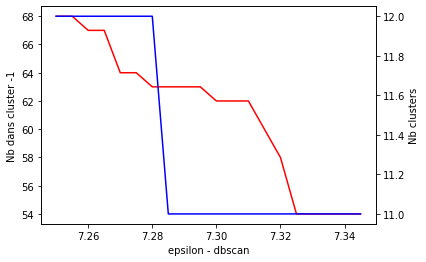

In [184]:
# Instanciating DBSCAN 
liste1 = []
liste2 = []
liste3 = []
for i in range(7250,7350, 5):
    db = DBSCAN(eps=i/10000, min_samples=6, metric="cosine", algorithm="auto")
    # Fiting on data 
    db.fit(data)
    df['db_cluster']=db.labels_
    liste1.append(len(df[df['db_cluster'] == -1]))
    liste2.append(df['db_cluster'].nunique())
    liste3.append(i/1000)
fig, ax1 = plt.subplots() 

ax1.set_xlabel('epsilon - dbscan') 
ax1.set_ylabel('Nb dans cluster -1') 
ax1.plot(liste3,liste1, color = 'red') 

# Adding Twin Axes

ax2 = ax1.twinx() 
ax2.plot(liste3,liste2, color = 'blue')  

# Add label

plt.ylabel('Nb clusters') 

# Show plot
plt.show()
fig.clear(True)
liste1 = []
liste2 = []
liste3 = []


In [185]:
db = DBSCAN(eps=0.728, min_samples=6, metric="cosine", algorithm="auto")
# Fiting on data 
db.fit(data)

DBSCAN(eps=0.728, metric='cosine', min_samples=6)

In [186]:
df['db_cluster']=db.labels_
print('number of identified clusters: ',df['db_cluster'].nunique())

number of identified clusters:  12


Répartition des documents dans les dix clusters

In [187]:
df['db_cluster'].value_counts().sort_values(ascending=False)

 0     182
 4      67
-1      63
 5      57
 1      33
 7      24
 8      20
 9      20
 2       9
 3       9
 6       8
 10      8
Name: db_cluster, dtype: int64

In [188]:
df['product'] = df['description'].apply(lambda x:x.split(' - ')[0])
df.head()

,id,description,description_nohtml,cleaned_nohtml,desc_tokens,desc_lemma,clean_lemma,clean_tokens,db_cluster,product
0,1,Active classic boxers - There's a reason why o...,Active classic boxers - There's a reason why o...,active classic boxers there reason why our box...,"[active, classic, boxers, reason, boxers, cult...","[active, classic, boxer, reason, boxer, cult, ...",active classic boxer reason boxer cult favorit...,active classic boxers reason boxers cult favor...,4,Active classic boxers
1,2,Active sport boxer briefs - Skinning up Glory ...,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning glory requi...,"[active, sport, boxer, briefs, skinning, glory...","[active, sport, boxer, brief, skin, glory, req...",active sport boxer brief skin glory require mo...,active sport boxer briefs skinning glory requi...,-1,Active sport boxer briefs
2,3,Active sport briefs - These superbreathable no...,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable fly ...,"[active, sport, briefs, superbreathable, fly, ...","[active, sport, brief, superbreathable, fly, b...",active sport brief superbreathable fly brief m...,active sport briefs superbreathable fly briefs...,4,Active sport briefs
3,4,"Alpine guide pants - Skin in, climb ice, switc...","Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin climb ice switch rock ...,"[alpine, guide, pants, skin, climb, ice, switc...","[alpine, guide, pant, skin, climb, ice, switch...",alpine guide pant skin climb ice switch rock t...,alpine guide pants skin climb ice switch rock ...,0,Alpine guide pants
4,5,"Alpine wind jkt - On high ridges, steep ice an...","Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt high ridges steep ice and anyt...,"[alpine, wind, jkt, high, ridges, steep, ice, ...","[alpine, wind, jkt, high, ridge, steep, ice, a...",alpine wind jkt high ridge steep ice alpine ja...,alpine wind jkt high ridges steep ice alpine j...,0,Alpine wind jkt


CLUSTER n°0



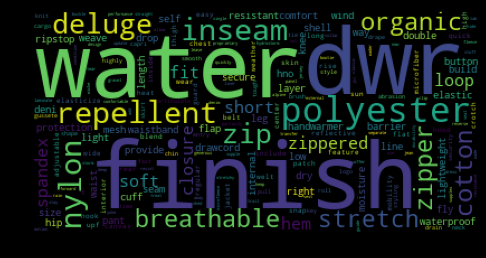

-----------
CLUSTER n°1



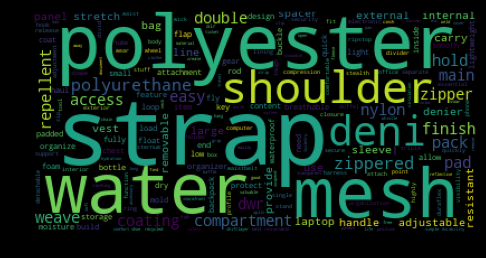

-----------
CLUSTER n°2



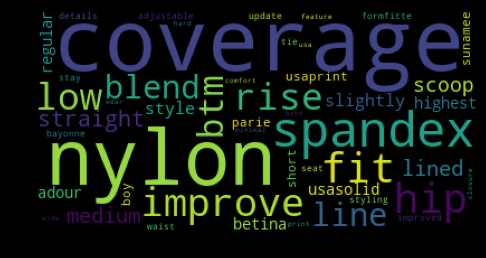

-----------
CLUSTER n°3



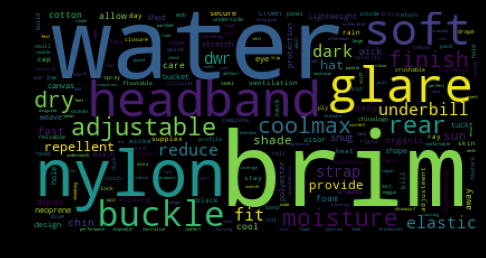

-----------
CLUSTER n°4



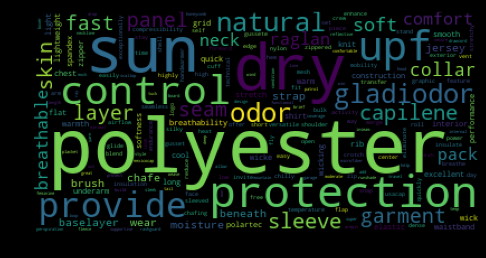

-----------
CLUSTER n°5



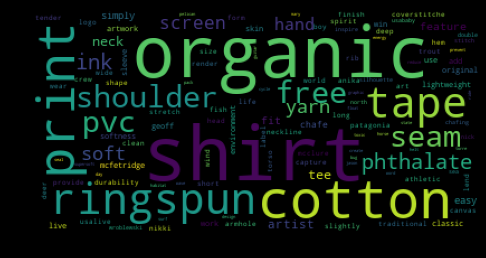

-----------
CLUSTER n°6



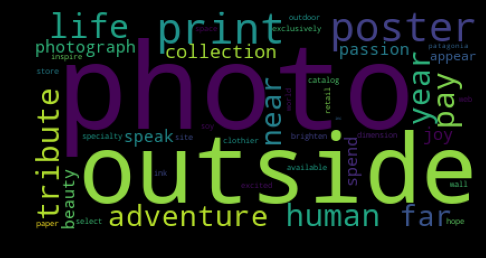

-----------
CLUSTER n°7



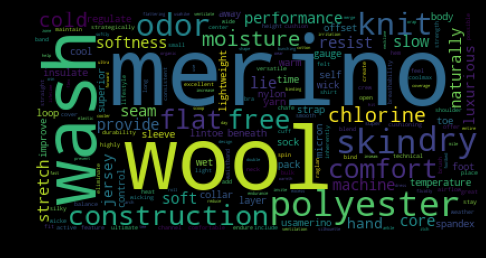

-----------
CLUSTER n°8



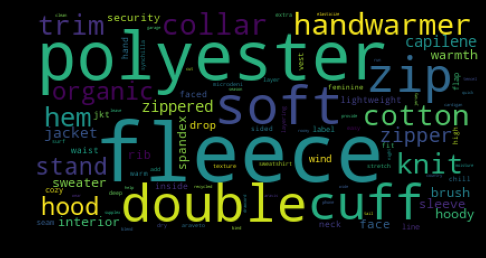

-----------
CLUSTER n°9



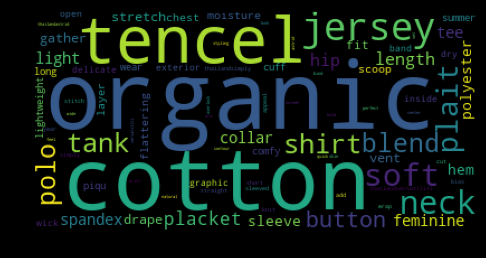

-----------
CLUSTER n°10



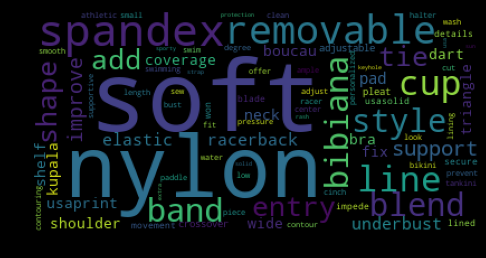

-----------


In [189]:
import matplotlib.pyplot as plt
import wordcloud
for i in range(0,11):
    text_merge_clean_token = ''
    df_temp = df[df['db_cluster'] == i]
    for j in range(0, len(df_temp)):
        text_merge_clean_token += str(df_temp['clean_lemma'].iloc[j])
    print('CLUSTER n°' + str(i)+'\n')
    wd = wordcloud.WordCloud(collocations=False)
    cloud = wd.generate(nlp(text_merge_clean_token).text)
    fig = plt.figure(
    figsize = (8, 5),
    facecolor = 'k',
    edgecolor = 'k')
    plt.imshow(cloud )

    # Remove trailing logs 
    plt.show()
    print('-----------')

Fonction de recommandation de produits similaires

In [192]:
def find_similar_items(item_id):
    item_id = int(item_id)
    db_cluster_target = df[df['id'] == item_id]['db_cluster'].tolist()[0]
    df_filtre = df[df['db_cluster'] == db_cluster_target]
    result = df_filtre['product'].sample(5).to_list()
    return result
find_similar_items(input())

 1


['L/s sol patrol shirt',
 'Cap 3 zip neck',
 'Cap 4 bottoms',
 'Cap 2 v-neck',
 'S/s el ray shirt']

In [193]:
liste = []
for i in range(10,21):
    svd = TruncatedSVD(n_components=i, algorithm='randomized', n_iter=50)
    lsa = svd.fit_transform(X)
    var_explained = svd.explained_variance_ratio_.sum()
    liste.append(var_explained)
print('La variance max est de : '+str(max(liste))+' pour n_components = ' +str(10 + liste.index(max(liste))))

La variance max est de : 0.302342850491733 pour n_components = 20


In [226]:
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', random_state=122)
lsa = svd_model.fit_transform(X)

topic_encoded_df = pd.DataFrame(lsa, columns = ["topic " + str(i) for i in range(0,20)])
topic_encoded_df["documents"] = df['clean_lemma']
topic_encoded_df

,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,...,topic 11,topic 12,topic 13,topic 14,topic 15,topic 16,topic 17,topic 18,topic 19,documents
0,0.220663,-0.075687,0.170213,0.087549,-0.121743,-0.003310,0.065442,0.092204,-0.135421,0.009661,...,-0.003497,0.059029,-0.020891,0.027160,0.008330,0.014176,-0.000043,0.033911,-0.023460,active classic boxer reason boxer cult favorit...
1,0.264380,-0.070817,0.076231,0.112034,-0.037087,-0.142692,-0.002453,0.008253,-0.143254,-0.015733,...,0.041267,0.089076,-0.045595,-0.063651,0.127858,-0.049052,0.098718,0.092203,0.032069,active sport boxer brief skin glory require mo...
2,0.252521,-0.102865,0.084736,0.029473,-0.036303,-0.117984,-0.118913,-0.004187,-0.097069,0.058342,...,0.088213,0.106237,-0.059303,-0.075184,0.130973,-0.077011,0.041174,0.075215,0.051015,active sport brief superbreathable fly brief m...
3,0.377401,-0.244648,-0.163218,-0.133653,0.060503,-0.037132,0.067286,0.002121,-0.089573,-0.147859,...,-0.095751,0.116430,0.166164,-0.042648,0.195599,-0.132659,-0.082990,0.012127,0.108612,alpine guide pant skin climb ice switch rock t...
4,0.391374,-0.255983,-0.050472,-0.235369,-0.024019,0.047825,-0.066288,-0.000474,-0.007360,-0.230935,...,-0.202976,0.236269,-0.173075,0.050467,-0.030107,0.045701,0.008914,0.018439,0.054568,alpine wind jkt high ridge steep ice alpine ja...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.305639,-0.108898,0.375389,0.076671,-0.260754,0.056758,0.177425,0.119955,-0.298826,0.050065,...,-0.042763,0.043142,0.010294,-0.020206,0.025354,0.014961,-0.056250,-0.082655,0.010920,cap cut loose madden crowd search undone capil...
496,0.345489,-0.106238,0.484240,-0.015545,-0.308799,0.111815,0.073759,0.138374,-0.179810,0.090344,...,-0.137831,-0.008198,-0.110707,-0.024136,0.069173,0.034723,0.088025,-0.159588,-0.060760,cap crew crew edge fickle weather clearing con...
497,0.299932,-0.224810,-0.106043,-0.254573,0.045182,0.212674,0.131996,-0.129571,0.059559,0.073506,...,0.055027,-0.118226,-0.049380,0.012093,-0.042852,-0.008125,-0.006940,-0.006217,-0.017275,time shell need use morning time umbrella time...
498,0.256650,0.096100,-0.111758,0.359598,0.028859,0.098072,0.134988,0.162677,0.030907,-0.021642,...,0.018742,-0.038643,-0.198165,-0.150170,-0.249321,-0.043351,0.156960,0.038027,0.029431,wear cargo short wear cargo short bask glory s...


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='topic_1', ylabel='topic_3'>

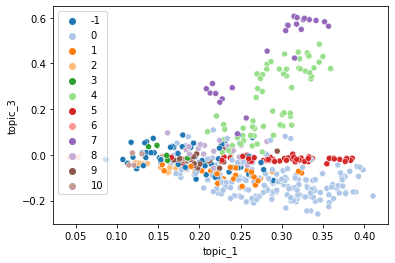

In [217]:
import seaborn as sns
sns.scatterplot("topic_1","topic_3",data= topic_encoded_df, hue = db.labels_, palette=sns.color_palette("tab20")[0:12])

In [235]:
def main_topic(row):
    topics = np.abs(row)
    main_topic = topics.sort_values(ascending=False).index[0]
    return main_topic

topic_encoded_df.loc[:, 'main_topic'] = 0

for i, row in topic_encoded_df.iloc[:,:-2].iterrows():
    topic_encoded_df.loc[i, 'main_topic'] = main_topic(row)

topic_encoded_df.head()

,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,...,topic 12,topic 13,topic 14,topic 15,topic 16,topic 17,topic 18,topic 19,documents,main_topic
0,0.220663,-0.075687,0.170213,0.087549,-0.121743,-0.003310,0.065442,0.092204,-0.135421,0.009661,...,0.059029,-0.020891,0.027160,0.008330,0.014176,-0.000043,0.033911,-0.023460,active classic boxer reason boxer cult favorit...,topic 0
1,0.264380,-0.070817,0.076231,0.112034,-0.037087,-0.142692,-0.002453,0.008253,-0.143254,-0.015733,...,0.089076,-0.045595,-0.063651,0.127858,-0.049052,0.098718,0.092203,0.032069,active sport boxer brief skin glory require mo...,topic 0
2,0.252521,-0.102865,0.084736,0.029473,-0.036303,-0.117984,-0.118913,-0.004187,-0.097069,0.058342,...,0.106237,-0.059303,-0.075184,0.130973,-0.077011,0.041174,0.075215,0.051015,active sport brief superbreathable fly brief m...,topic 0
3,0.377401,-0.244648,-0.163218,-0.133653,0.060503,-0.037132,0.067286,0.002121,-0.089573,-0.147859,...,0.116430,0.166164,-0.042648,0.195599,-0.132659,-0.082990,0.012127,0.108612,alpine guide pant skin climb ice switch rock t...,topic 0
4,0.391374,-0.255983,-0.050472,-0.235369,-0.024019,0.047825,-0.066288,-0.000474,-0.007360,-0.230935,...,0.236269,-0.173075,0.050467,-0.030107,0.045701,0.008914,0.018439,0.054568,alpine wind jkt high ridge steep ice alpine ja...,topic 0


In [ ]:
topic_encoded_df['main_topic'].value_counts()

topic 0     215
topic 1      61
topic 7      37
topic 2      32
topic 3      28
topic 4      19
topic 8      17
topic 11     16
topic 19     12
topic 5      11
topic 6      10
topic 9       9
topic 10      8
topic 13      6
topic 16      5
topic 15      4
topic 18      4
topic 17      3
topic 12      2
topic 14      1
Name: main_topic, dtype: int64

In [238]:
desc_topic = pd.DataFrame(svd.components_, 
                                  columns = vectorizer.get_feature_names(), 
                                  index = ['topic_' + str(i) for i in range(svd.components_.shape[0])])

desc_topic = desc_topic.apply(np.abs, axis = 1)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic n°0


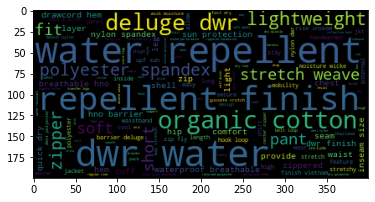

Topic n°1


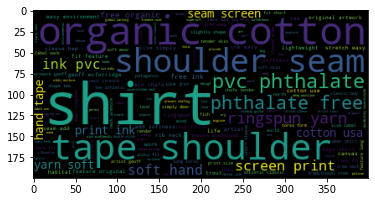

Topic n°2


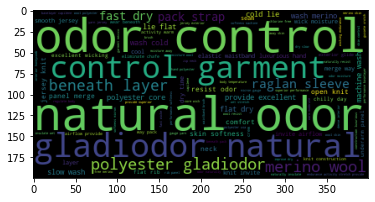

Topic n°3


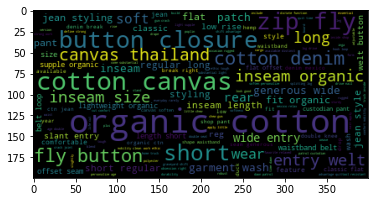

Topic n°4


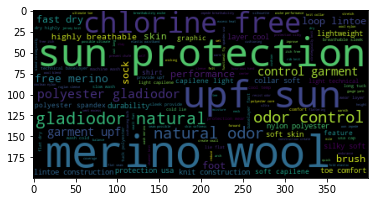

Topic n°5


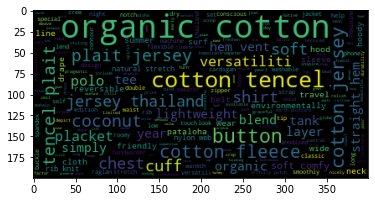

Topic n°6


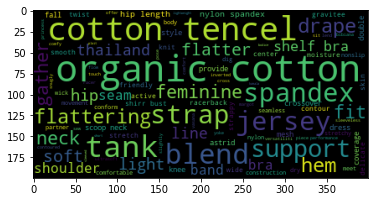

Topic n°7


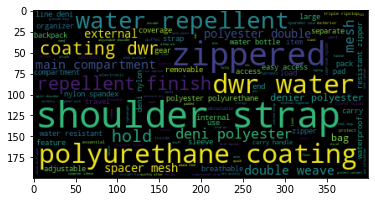

Topic n°8


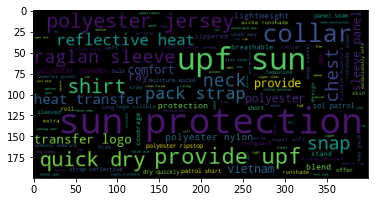

Topic n°9


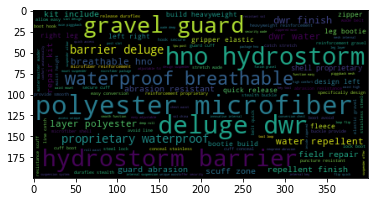

Topic n°10


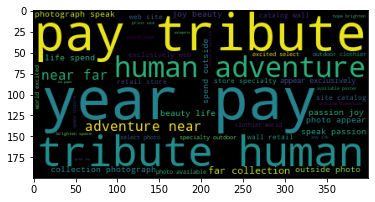

Topic n°11


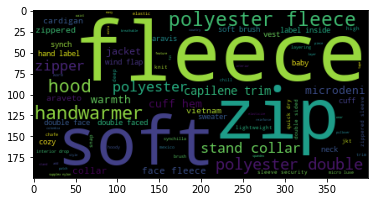

Topic n°12


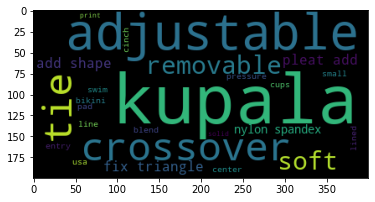

Topic n°13


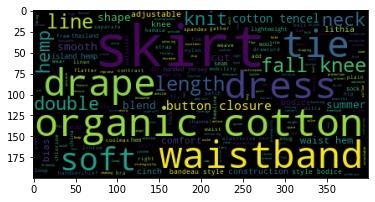

Topic n°14


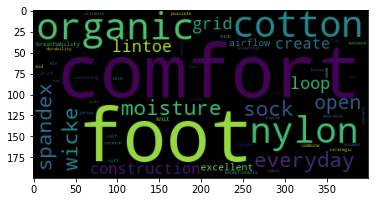

Topic n°15


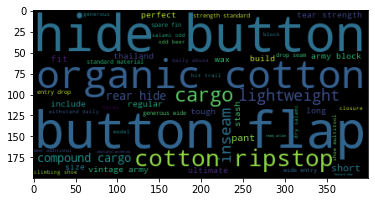

Topic n°16


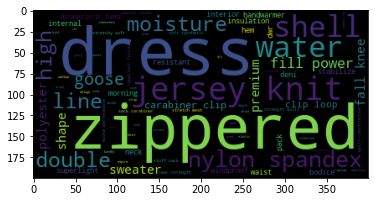

Topic n°17


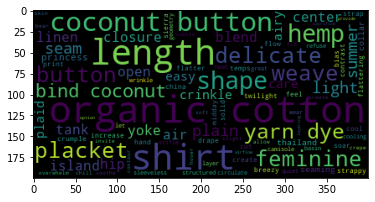

Topic n°18


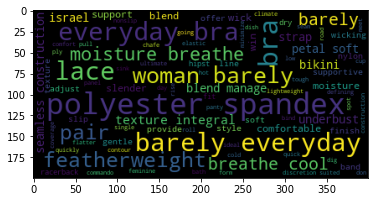

Topic n°19


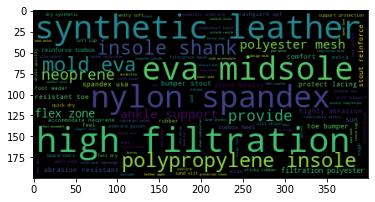

In [249]:
wd = wordcloud.WordCloud()
col = [c for c in topic_encoded_df.columns if 'topic ' in c]
inc = 0
for topic in col:
    print('Topic n°' + str(inc))
    texts = " ".join(topic_encoded_df.loc[topic_encoded_df['main_topic']==topic,'documents'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    inc += 1